# Forward model.


1. Fluorescence lifetime spectrum
2. Convolution with instrument
3. Pile up single photon counting electronics
4. Differential non-linearities
5. Background (either constant or patterned)


Scoring

1. Counting noise



## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import IMP
import IMP.bff

## Settings
Somtimes not all settings are found in fluorescence decay datasets. For instance, the example dataset does not contain information on the time-resolution (i.e., bin width of the fluorescence decay histogram). 

In [2]:
dt = 0.0141 # time resolution (bin width of decay histogram)

## Input data

In [3]:
fns = {
    "lintable": IMP.bff.get_example_path("spectroscopy/hgbp1/eTCSPC_whitelight.txt"),
    "irf": IMP.bff.get_example_path("spectroscopy/hgbp1/eTCSPC_Prompt.txt"),
    "donor": IMP.bff.get_example_path("spectroscopy/hgbp1/eTCSPC_Donor.txt"),
    "fret": IMP.bff.get_example_path("spectroscopy/hgbp1/eTCSPC_FRET.txt")
}

data = dict()
for key in fns:
    df = pd.read_csv(fns[key], skiprows=6, sep='\t')
    data[key] = IMP.bff.DecayCurve(x=df['Chan'] * dt, y=df['Data'])

/opt/tljh/user/envs/dev/lib/python3.9/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/opt/tljh/user/envs/dev/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


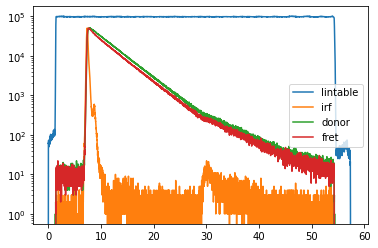

In [4]:
for key in data:
    d = data[key]
    plt.semilogy(d.x, d.y, label=key)

plt.legend()
plt.show()

## Model decay
Compute fluorescence decay using a set of parameters and an experimental instrument response function (irf). 

### Output object
Create an empty `IMP.bff.DecayCurve` object of size of the irf.

In [5]:
decay = IMP.bff.DecayCurve(x=data["irf"].x)
decay.sum()

0.0

### Lifetime handler

As a firs step, a set of lifetimes with corresponding amplitudes are defined. Lifetimes and amplitudes are handeled by `IMP.bff.DecayLifetimeHandler` objects.

In [6]:
lifetime_spectrum = np.array(
    [
        (0.8, 4.0), # pair of amplitude and lifetime
        (0.2, 2.0)
    ]
)
lifetime_settings = {
    'lifetime_spectrum': lifetime_spectrum.flatten(),
    'abs_lifetime_spectrum': False,   # True -> take abs of liftime spectrum
    'use_amplitude_threshold': False, # True -> discriminate lifetimes below threshold
    'amplitude_threshold': 0.0
}
lh = IMP.bff.DecayLifetimeHandler(**lifetime_settings)

### Convolution


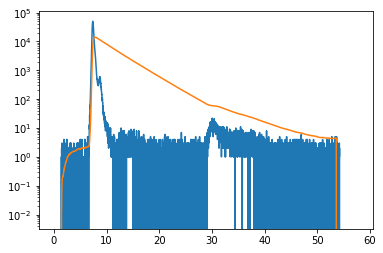

In [7]:
convolution_settings = {
    "lifetime_handler": lh,
    "instrument_response_function": data["irf"],
    "convolution_method": IMP.bff.DecayConvolution.FAST,
    "excitation_period": 100,
    "irf_shift_channels": 0.0,
    "irf_background_counts": 0.0,
    "start": 100, "stop": 3800
}
dc = IMP.bff.DecayConvolution(**convolution_settings)
dc(decay)
plt.semilogy(data["irf"].x, data["irf"].y)
plt.semilogy(decay.x, decay.y)
plt.show()

### Pile up



4096


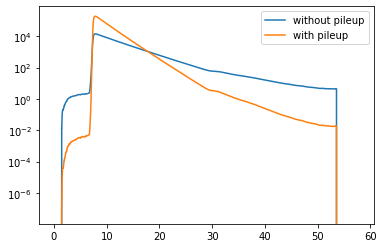

In [8]:
dp = IMP.bff.DecayPileup(decay)
y1 = decay.y
dp.add(decay)
y2 = decay.y

plt.semilogy(decay.x, y1, label="without pileup")
plt.semilogy(decay.x, y2, label="with pileup")
plt.legend()
plt.show()

### Background

patterned (non-constant) or constant background

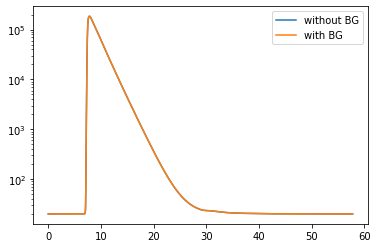

In [9]:
y1 = decay.y
bg = IMP.bff.DecayPattern(20.0) # Background
bg.add(decay)
plt.semilogy(decay.x, decay.y, label="without BG")
plt.semilogy(decay.x, decay.y, label="with BG")
plt.legend()
plt.show()

### Differential non linearities

`IMP.bff.DecayLinearization` calls `IMP.bff.DecayCurve.apply_simple_moving_average` to compute a simple moving average filter on the data modifies a `IMP.bff.DecayCurve` when `IMP.bff.DecayLinearization.add` is called.

4096
18446744073709551615


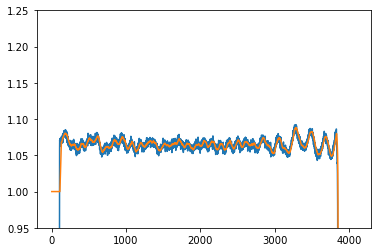

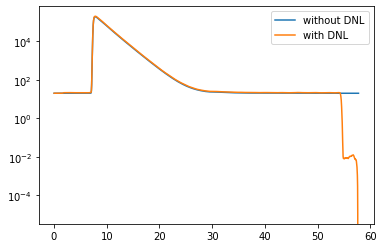

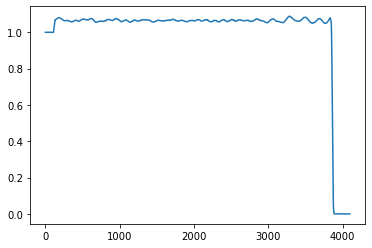

In [10]:
lin_start, lin_stop = 110, -1
dnl = IMP.bff.DecayLinearization(
    data["lintable"],
    start=lin_start, stop=lin_stop, n_window=20
)
print(dnl.get_stop(data["lintable"]))
print(dnl.get_stop())

lt = dnl.get_linearization_table()
noisy = np.array(data["lintable"].y)
n2 = noisy / np.mean(noisy[lin_start: lin_stop])

plt.plot(n2)
plt.plot(lt.y)
plt.ylim([0.95, 1.25])
plt.show()

y1 = decay.y
dnl.add(decay)
y2 = decay.y

plt.semilogy(decay.x, y1, label="without DNL")
plt.semilogy(decay.x, y2, label="with DNL")
plt.legend()
plt.show()

plt.plot(y2/y1)
plt.show()

## Compute decay with noise

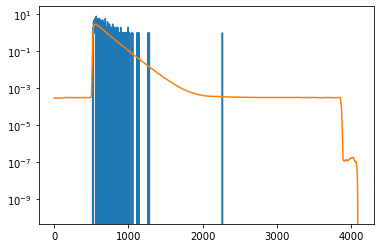

In [11]:
number_of_photons = 500

x = decay.x
y = decay.y
y /= np.sum(y)
y *= number_of_photons
y_noise = np.random.poisson(y)

decay_noisy = IMP.bff.DecayCurve(x, y_noise)
plt.semilogy(y_noise)
plt.semilogy(y)
plt.show()

## Scale to data

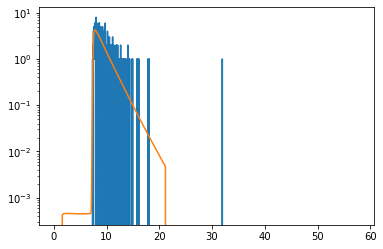

Sum(data): 489.0
Sum(model): 699.3595207004698


In [12]:
dsc = IMP.bff.DecayScale(decay_noisy, start=110, stop=1500)
dsc.add(decay)

plt.semilogy(decay_noisy.x, decay_noisy.y)
plt.semilogy(decay.x, decay.y)
plt.show()
print("Sum(data):", decay_noisy.y.sum())
print("Sum(model):", decay.y.sum())

## Score

In [13]:
score_kw = {
    "model": decay,
    "data": decay_noisy,
    "score_type": "sswr", #poisson, pearson, gauss, cnp, sswr (sum of weighte squared residuals)
    "start": 110,
    "stop": 1600
}
decay_score = IMP.bff.DecayScore(**score_kw)
score = decay_score.get_score()
n_ch = score_kw["stop"] - score_kw["start"]
score_r = score / n_ch
print("Score:", score)
print("Reduced score:", score_r)

Score: 437.79629638215954
Reduced score: 0.2938230177061473
